# Time Series Forecasting Model using Machine Learning ⏱
The purpose of this notebook is to create a Time_series Forecast Model which could predict the Pull/Call for the given dataset.



Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.
More specifically, we'll look at the following topics.

* **Exploratory data analysis (EDA)** - the process of going through a dataset and finding out more about it.
* **Model training** - create model(s) to learn to predict a target variable based on other variables.
* **Model evaluation** - evaluating a models predictions using problem-specific evaluation metrics. 
* **Cross-validation** - if we do build a good model, can we be sure it will work on unseen data?
* **Predicting the Test Data** - We now finally, predict the target using out trained model and the test data.
* **Plotting the Aquired Values** - We can visually validate the predicted values by seeing the trends on the plot

## 1. Importing required packages

In [1]:
# Regular EDA and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError
import datetime
from math import *

#To get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# We want our plots to appear in the notebook
%matplotlib inline

## Models
from statsmodels.tsa.vector_ar.var_model import VAR

## Model evaluators
from sklearn.metrics import mean_squared_error

## 2. Data Exploration

Data can be found in `Data/` Folder. 
The ones we are going to use:
* `Test_dataset - Put-Call_TS.csv`


Once we have imported our data, we are going to explore and get to know about the different Attributes and their patterns with the data.

Data Exploration is one of most important tasks in Machine Learning.

We edited the given raw .xlsx file as it wasn't oraganized properly for `pandas` to read it.

Because of this issue the imported data would have `Object` as dtype instead `int64`.

**Note :** We havent manuplated data outside the notebook. You can cross verify with the .csv file

In [2]:
# Importing the Data
data = pd.read_csv("data/Test_dataset - Put-Call_TS.csv")

### 2.1 Minor Changes to the Index of the Data
There is a seperate column for `Stock Data` which is set as default index and the column is dropped.

In [3]:
data.index = data["Stock Index"] #Stock Index Column is set as default Index

data.drop('Stock Index',inplace=True, axis=1) 
# As this column is set as default index, we no lomger require this column
data

,10-Aug,11-Aug,12-Aug,13-Aug,14-Aug,15-Aug
Stock Index,,,,,,
AC3235,0.80,0.660,0.77240,0.983224,0.901211,0.898368
AC3236,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AC3237,0.93,0.816,0.95024,1.207302,NaN,1.181962
AC3238,1.09,1.008,1.16912,1.483091,1.461062,1.531000
AC3239,NaN,1.104,1.27856,1.620986,1.615504,1.705519
...,...,...,...,...,...,...
AD2734,0.86,0.732,0.85448,1.086645,1.017042,1.029258
AD2735,0.64,0.468,0.55352,0.707435,0.592327,0.549330
AD2736,0.67,0.504,0.59456,0.759146,0.650243,0.614775


In [4]:
data.info() #Gives Insight about different Attributes

<class 'pandas.core.frame.DataFrame'>
Index: 3331 entries, AC3235 to AD2738
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   10-Aug  2902 non-null   float64
 1   11-Aug  3329 non-null   float64
 2   12-Aug  3274 non-null   float64
 3   13-Aug  3317 non-null   float64
 4   14-Aug  3226 non-null   float64
 5   15-Aug  3092 non-null   float64
dtypes: float64(6)
memory usage: 182.2+ KB


### 2.2 Filling Missing Values
Here we are using `pd.interpolate()` because that is optimal way of filling the missing values in a Time-Series DataSet. We could also fill with the `mean()` but in our case `pd.interpolate()` would work the best as the Columns and Rows are linearly depended too.


In [5]:
data.isna().sum() # Returns count of missing values

10-Aug    429
11-Aug      2
12-Aug     57
13-Aug     14
14-Aug    105
15-Aug    239
dtype: int64

In [6]:
data = data.interpolate() # To fill Missing Values

In [7]:
data.isna().sum() # All the missing are Handled

10-Aug    0
11-Aug    0
12-Aug    0
13-Aug    0
14-Aug    0
15-Aug    0
dtype: int64

In [8]:
data = data.T # Transposing the Data 
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
10-Aug,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
11-Aug,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
12-Aug,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
13-Aug,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
14-Aug,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
15-Aug,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.3 Parsing Indexes in DateTime Format
As this is Time-Series Problem its best to have `DateTime Object` as our indexes

In [9]:
data.index=pd.date_range("8/10/2020", freq="D", periods=6)
data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479


### 2.4 Splitting the Data
The Data should be splitted into **train** and **test** .

* **Train** Data is used to train the model.

* **Test** Data is used to evaluate the model.

In [10]:
train = data[:int(0.9*(len(data)))]
valid = data[int(0.9*(len(data))):]

In [11]:
train #Data from Aug 10th to Aug 14th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380


In [12]:
valid #Data on Aug 15th

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-15,0.898368,1.029258,1.181962,1.531,1.705519,1.792779,1.836409,1.334666,1.334666,1.48737,...,1.029258,0.46207,0.789294,1.312851,1.356481,1.029258,0.54933,0.614775,0.876553,0.767479


## 3. Training Our Model
We've explored the data, now we'll try to use machine learning to predict our target variable

Best Algorithm for this problem is : **VAR** : Vector Autoregression is most commonly used methods for multivariate time series forecasting.



In [13]:
# Training our model using Trained Data
model = VAR(endog=train)
model_fit = model.fit()
model_fit.y

array([[0.8       , 0.86      , 0.93      , ..., 0.67      , 0.79      ,
        0.74      ],
       [0.66      , 0.732     , 0.816     , ..., 0.504     , 0.648     ,
        0.588     ],
       [0.7724    , 0.85448   , 0.95024   , ..., 0.59456   , 0.75872   ,
        0.69032   ],
       [0.983224  , 1.0866448 , 1.2073024 , ..., 0.7591456 , 0.9659872 ,
        0.8798032 ],
       [0.90121088, 1.01704218, 1.23905216, ..., 0.65024307, 0.88190566,
        0.78537958]])

In [14]:
cols = data.columns

prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])

# For loop to append all the predictions to a DataFrame : pred
for j in range(0,3331):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [15]:
pred.index = [datetime.datetime(2020, 8, 15)]
pred.T #These are the values predicted by the for August 15th

,2020-08-15
Stock Index,
AC3235,1.01983
AC3236,1.138537
AC3237,1.323383
AC3238,1.593582
AC3239,1.751858
...,...
AD2734,1.138537
AD2735,0.703277
AD2736,0.76263


## 4. Model Evaluation
Our model has just predicted the values for August 15th. We will be comparing these value with valid values. 

### Root Mean Square Error
The **root-mean-square error (RMSE)** is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.

The below for loop will output RMSE Value for each Stock. And all the values are nearer to zero as they should be.

In [16]:
# The below for loop will output RMSE Value for each Stock(3331 Stocks). 
# And all the values are nearer to zero as they should be.

for i in cols:
    print('RMSE Value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

RMSE Value for AC3235 is :  0.12146140913346715
RMSE Value for AC3236 is :  0.10927940928599567
RMSE Value for AC3237 is :  0.14142062572883107
RMSE Value for AC3238 is :  0.06258174503735447
RMSE Value for AC3239 is :  0.04633907990739172
RMSE Value for AC3240 is :  0.03821774634241004
RMSE Value for AC3241 is :  0.034157080059920464
RMSE Value for AC3242 is :  0.08085474430856188
RMSE Value for AC3243 is :  0.08085474430856188
RMSE Value for AC3244 is :  0.05532088785756151
RMSE Value for AC3245 is :  0.07476374488482596
RMSE Value for AC3246 is :  0.10521874300350498
RMSE Value for AC3247 is :  0.13973440740467535
RMSE Value for AC3248 is :  0.16343189356205334
RMSE Value for AC3249 is :  0.16700768016669776
RMSE Value for AC3250 is :  0.15800740667588276
RMSE Value for AC3251 is :  0.1458254078284117
RMSE Value for AC3252 is :  0.06258174503735447
RMSE Value for AC3253 is :  0.1559770735346384
RMSE Value for AC3254 is :  0.07679407802607141
RMSE Value for AC3255 is :  0.05852107875

RMSE Value for AC3433 is :  0.04633907990739172
RMSE Value for AC3434 is :  0.1295827416984492
RMSE Value for AC3435 is :  0.09303674315603394
RMSE Value for AC3436 is :  0.048369413048638066
RMSE Value for AC3437 is :  0.05852107875486423
RMSE Value for AC3438 is :  0.07476374488482596
RMSE Value for AC3439 is :  0.0950670772972797
RMSE Value for AC3440 is :  0.12146140913346715
RMSE Value for AC3441 is :  0.021975081212449288
RMSE Value for AC3442 is :  0.10318840986226085
RMSE Value for AC3443 is :  0.007348741375086343
RMSE Value for AC3444 is :  0.21978711792766958
RMSE Value for AC3445 is :  0.03635713342017599
RMSE Value for AC3446 is :  0.299392459948308
RMSE Value for AC3447 is :  0.3020232004840644
RMSE Value for AC3448 is :  0.3732006246080546
RMSE Value for AC3449 is :  0.22150252507382218
RMSE Value for AC3450 is :  0.28126416090582707
RMSE Value for AC3451 is :  0.27644562473128087
RMSE Value for AC3452 is :  0.2509833056115489
RMSE Value for AC3453 is :  0.32216072973554

RMSE Value for AC3632 is :  0.1539467403933924
RMSE Value for AC3633 is :  0.12552207541595828
RMSE Value for AC3634 is :  0.034157080059920464
RMSE Value for AC3635 is :  0.12146140913346715
RMSE Value for AC3636 is :  0.1316130748396941
RMSE Value for AC3637 is :  0.08694574373229846
RMSE Value for AC3638 is :  0.15191640725214772
RMSE Value for AC3639 is :  0.09709741043852449
RMSE Value for AC3640 is :  0.11334007556848713
RMSE Value for AC3641 is :  0.07273341174358139
RMSE Value for AC3642 is :  0.09709741043852449
RMSE Value for AC3643 is :  0.04633907990739172
RMSE Value for AC3644 is :  0.0991277435797695
RMSE Value for AC3645 is :  0.0950670772972797
RMSE Value for AC3646 is :  0.16206807295837294
RMSE Value for AC3647 is :  0.03821774634241004
RMSE Value for AC3648 is :  0.10318840986226085
RMSE Value for AC3649 is :  0.10318840986226085
RMSE Value for AC3650 is :  0.1275524085572035
RMSE Value for AC3651 is :  0.13567374112218444
RMSE Value for AC3652 is :  0.08694574373229

RMSE Value for AD32 is :  0.06867274546109026
RMSE Value for AD33 is :  0.15800740667588276
RMSE Value for AD34 is :  0.08694574373229846
RMSE Value for AD35 is :  0.05243007933112698
RMSE Value for AD36 is :  0.13567374112218444
RMSE Value for AD37 is :  0.13364340798093932
RMSE Value for AD38 is :  0.10724907614475088
RMSE Value for AD39 is :  0.08491541059105279
RMSE Value for AD40 is :  0.08288507744980711
RMSE Value for AD41 is :  0.060551411896108354
RMSE Value for AD42 is :  0.05649074561361833
RMSE Value for AD43 is :  0.10521874300350498
RMSE Value for AD44 is :  0.13973440740467535
RMSE Value for AD45 is :  0.05243007933112698
RMSE Value for AD46 is :  0.1275524085572035
RMSE Value for AD47 is :  0.0950670772972797
RMSE Value for AD48 is :  0.04430874676614671
RMSE Value for AD49 is :  0.11537040870973214
RMSE Value for AD50 is :  0.07476374488482596
RMSE Value for AD51 is :  0.07070307860233616
RMSE Value for AD52 is :  0.15800740667588276
RMSE Value for AD53 is :  0.0402480

RMSE Value for AD282 is :  0.10115807672101518
RMSE Value for AD283 is :  0.11740074185097826
RMSE Value for AD284 is :  0.1275524085572035
RMSE Value for AD285 is :  0.12146140913346715
RMSE Value for AD286 is :  0.13567374112218444
RMSE Value for AD287 is :  0.11740074185097826
RMSE Value for AD288 is :  0.10318840986226085
RMSE Value for AD289 is :  0.1234917422747136
RMSE Value for AD290 is :  0.1498860741109025
RMSE Value for AD291 is :  0.06664241131984383
RMSE Value for AD292 is :  0.1295827416984492
RMSE Value for AD293 is :  0.08288507744980711
RMSE Value for AD294 is :  0.07882441116731664
RMSE Value for AD295 is :  0.10724907614475088
RMSE Value for AD296 is :  0.07070307860233616
RMSE Value for AD297 is :  0.036187413201165475
RMSE Value for AD298 is :  0.13567374112218444
RMSE Value for AD299 is :  0.11943107499222261
RMSE Value for AD300 is :  0.04430874676614671
RMSE Value for AD301 is :  0.021975081212449288
RMSE Value for AD302 is :  0.1417647405459208
RMSE Value for A

RMSE Value for AD516 is :  0.02682133539656628
RMSE Value for AD517 is :  0.5644538421769609
RMSE Value for AD518 is :  0.5679032057709781
RMSE Value for AD519 is :  0.47722915614900496
RMSE Value for AD520 is :  0.11765769709740326
RMSE Value for AD521 is :  0.8156660268580852
RMSE Value for AD522 is :  0.1464403212544425
RMSE Value for AD523 is :  0.8423493149048751
RMSE Value for AD524 is :  0.27204641359500403
RMSE Value for AD525 is :  0.1172192903189837
RMSE Value for AD526 is :  0.3937299284146212
RMSE Value for AD527 is :  0.4604555521058491
RMSE Value for AD528 is :  0.008860015948507494
RMSE Value for AD529 is :  0.22510535076253269
RMSE Value for AD530 is :  0.7873566166279751
RMSE Value for AD531 is :  0.41605223216204523
RMSE Value for AD532 is :  0.4974869309346881
RMSE Value for AD533 is :  0.7581355856925164
RMSE Value for AD534 is :  0.029556197512610183
RMSE Value for AD535 is :  0.4286967782817208
RMSE Value for AD536 is :  0.09580860727690821
RMSE Value for AD537 is

RMSE Value for AD693 is :  0.07273341174358139
RMSE Value for AD694 is :  0.034157080059920464
RMSE Value for AD695 is :  0.11130974242724245
RMSE Value for AD696 is :  0.1295827416984492
RMSE Value for AD697 is :  0.06867274546109026
RMSE Value for AD698 is :  0.13770407426343056
RMSE Value for AD699 is :  0.1437950736871656
RMSE Value for AD700 is :  0.10318840986226085
RMSE Value for AD701 is :  0.07273341174358139
RMSE Value for AD702 is :  0.1295827416984492
RMSE Value for AD703 is :  0.1498860741109025
RMSE Value for AD704 is :  0.08897607687354392
RMSE Value for AD705 is :  0.15800740667588276
RMSE Value for AD706 is :  0.15800740667588276
RMSE Value for AD707 is :  0.13567374112218444
RMSE Value for AD708 is :  0.030096413777429998
RMSE Value for AD709 is :  0.0503997461898833
RMSE Value for AD710 is :  0.05243007933112698
RMSE Value for AD711 is :  0.07882441116731664
RMSE Value for AD712 is :  0.1498860741109025
RMSE Value for AD713 is :  0.0240054143536943
RMSE Value for AD7

RMSE Value for AD935 is :  0.07476374488482596
RMSE Value for AD936 is :  0.08694574373229846
RMSE Value for AD937 is :  0.15800740667588276
RMSE Value for AD938 is :  0.13770407426343056
RMSE Value for AD939 is :  0.07679407802607141
RMSE Value for AD940 is :  0.08491541059105279
RMSE Value for AD941 is :  0.04227841262490095
RMSE Value for AD942 is :  0.1316130748396941
RMSE Value for AD943 is :  0.12146140913346715
RMSE Value for AD944 is :  0.04633907990739172
RMSE Value for AD945 is :  0.13567374112218444
RMSE Value for AD946 is :  0.13973440740467535
RMSE Value for AD947 is :  0.04024807948365594
RMSE Value for AD948 is :  0.16206807295837294
RMSE Value for AD949 is :  0.1478557409696567
RMSE Value for AD950 is :  0.06664241131984383
RMSE Value for AD951 is :  0.08085474430856188
RMSE Value for AD952 is :  0.09100641001478849
RMSE Value for AD953 is :  0.04430874676614671
RMSE Value for AD954 is :  0.08288507744980711
RMSE Value for AD955 is :  0.1498860741109025
RMSE Value for A

RMSE Value for AD1186 is :  0.05649074561361833
RMSE Value for AD1187 is :  0.1458254078284117
RMSE Value for AD1188 is :  0.11537040870973214
RMSE Value for AD1189 is :  0.030096413777429998
RMSE Value for AD1190 is :  0.07070307860233616
RMSE Value for AD1191 is :  0.11740074185097826
RMSE Value for AD1192 is :  0.10927940928599567
RMSE Value for AD1193 is :  0.06258174503735447
RMSE Value for AD1194 is :  0.08897607687354392
RMSE Value for AD1195 is :  0.0240054143536943
RMSE Value for AD1196 is :  0.08694574373229846
RMSE Value for AD1197 is :  0.02806608063618432
RMSE Value for AD1198 is :  0.1498860741109025
RMSE Value for AD1199 is :  0.1498860741109025
RMSE Value for AD1200 is :  0.1295827416984492
RMSE Value for AD1201 is :  0.10115807672101518
RMSE Value for AD1202 is :  0.07070307860233616
RMSE Value for AD1203 is :  0.06867274546109026
RMSE Value for AD1204 is :  0.11130974242724245
RMSE Value for AD1205 is :  0.05243007933112698
RMSE Value for AD1206 is :  0.09100641001478

RMSE Value for AD1373 is :  0.12146140913346715
RMSE Value for AD1374 is :  0.07070307860233616
RMSE Value for AD1375 is :  0.12146140913346715
RMSE Value for AD1376 is :  0.13567374112218444
RMSE Value for AD1377 is :  0.1478557409696567
RMSE Value for AD1378 is :  0.036187413201165475
RMSE Value for AD1379 is :  0.1275524085572035
RMSE Value for AD1380 is :  0.08491541059105279
RMSE Value for AD1381 is :  0.0503997461898833
RMSE Value for AD1382 is :  0.16206807295837294
RMSE Value for AD1383 is :  0.13364340798093932
RMSE Value for AD1384 is :  0.1498860741109025
RMSE Value for AD1385 is :  0.026035747494939532
RMSE Value for AD1386 is :  0.11130974242724245
RMSE Value for AD1387 is :  0.021975081212449288
RMSE Value for AD1388 is :  0.06664241131984383
RMSE Value for AD1389 is :  0.16003773981712854
RMSE Value for AD1390 is :  0.11334007556848713
RMSE Value for AD1391 is :  0.1437950736871656
RMSE Value for AD1392 is :  0.15800740667588276
RMSE Value for AD1393 is :  0.044308746766

RMSE Value for AD1638 is :  0.07273341174358139
RMSE Value for AD1639 is :  0.04633907990739172
RMSE Value for AD1640 is :  0.16206807295837294
RMSE Value for AD1641 is :  0.036187413201165475
RMSE Value for AD1642 is :  0.0950670772972797
RMSE Value for AD1643 is :  0.034157080059920464
RMSE Value for AD1644 is :  0.04227841262490095
RMSE Value for AD1645 is :  0.13364340798093932
RMSE Value for AD1646 is :  0.048369413048638066
RMSE Value for AD1647 is :  0.13364340798093932
RMSE Value for AD1648 is :  0.034157080059920464
RMSE Value for AD1649 is :  0.09303674315603394
RMSE Value for AD1650 is :  0.034157080059920464
RMSE Value for AD1651 is :  0.10521874300350498
RMSE Value for AD1652 is :  0.11943107499222261
RMSE Value for AD1653 is :  0.16206807295837294
RMSE Value for AD1654 is :  0.0240054143536943
RMSE Value for AD1655 is :  0.10521874300350498
RMSE Value for AD1656 is :  0.036187413201165475
RMSE Value for AD1657 is :  0.1498860741109025
RMSE Value for AD1658 is :  0.1011580

RMSE Value for AD1907 is :  0.060551411896108354
RMSE Value for AD1908 is :  0.03821774634241004
RMSE Value for AD1909 is :  0.15800740667588276
RMSE Value for AD1910 is :  0.06258174503735447
RMSE Value for AD1911 is :  0.05649074561361833
RMSE Value for AD1912 is :  0.11334007556848713
RMSE Value for AD1913 is :  0.05852107875486423
RMSE Value for AD1914 is :  0.10927940928599567
RMSE Value for AD1915 is :  0.13567374112218444
RMSE Value for AD1916 is :  0.10724907614475088
RMSE Value for AD1917 is :  0.11537040870973214
RMSE Value for AD1918 is :  0.034157080059920464
RMSE Value for AD1919 is :  0.10521874300350498
RMSE Value for AD1920 is :  0.13973440740467535
RMSE Value for AD1921 is :  0.15800740667588276
RMSE Value for AD1922 is :  0.1437950736871656
RMSE Value for AD1923 is :  0.10115807672101518
RMSE Value for AD1924 is :  0.11537040870973214
RMSE Value for AD1925 is :  0.026035747494939532
RMSE Value for AD1926 is :  0.13567374112218444
RMSE Value for AD1927 is :  0.12755240

RMSE Value for AD2151 is :  0.05649074561361833
RMSE Value for AD2152 is :  0.13567374112218444
RMSE Value for AD2153 is :  0.13567374112218444
RMSE Value for AD2154 is :  0.09100641001478849
RMSE Value for AD2155 is :  0.08897607687354392
RMSE Value for AD2156 is :  0.05649074561361833
RMSE Value for AD2157 is :  0.13567374112218444
RMSE Value for AD2158 is :  0.13364340798093932
RMSE Value for AD2159 is :  0.11130974242724245
RMSE Value for AD2160 is :  0.02806608063618432
RMSE Value for AD2161 is :  0.13770407426343056
RMSE Value for AD2162 is :  0.07070307860233616
RMSE Value for AD2163 is :  0.04633907990739172
RMSE Value for AD2164 is :  0.10521874300350498
RMSE Value for AD2165 is :  0.11537040870973214
RMSE Value for AD2166 is :  0.09303674315603394
RMSE Value for AD2167 is :  0.10521874300350498
RMSE Value for AD2168 is :  0.16206807295837294
RMSE Value for AD2169 is :  0.1478557409696567
RMSE Value for AD2170 is :  0.07882441116731664
RMSE Value for AD2171 is :  0.02603574749

RMSE Value for AD2340 is :  0.06258174503735447
RMSE Value for AD2341 is :  0.05243007933112698
RMSE Value for AD2342 is :  0.08288507744980711
RMSE Value for AD2343 is :  0.10724907614475088
RMSE Value for AD2344 is :  0.11740074185097826
RMSE Value for AD2345 is :  0.04430874676614671
RMSE Value for AD2346 is :  0.048369413048638066
RMSE Value for AD2347 is :  0.06258174503735447
RMSE Value for AD2348 is :  0.11943107499222261
RMSE Value for AD2349 is :  0.08085474430856188
RMSE Value for AD2350 is :  0.03821774634241004
RMSE Value for AD2351 is :  0.16206807295837294
RMSE Value for AD2352 is :  0.09303674315603394
RMSE Value for AD2353 is :  0.02806608063618432
RMSE Value for AD2354 is :  0.16206807295837294
RMSE Value for AD2355 is :  0.1275524085572035
RMSE Value for AD2356 is :  0.15191640725214772
RMSE Value for AD2357 is :  0.16003773981712854
RMSE Value for AD2358 is :  0.06461207817860015
RMSE Value for AD2359 is :  0.036187413201165475
RMSE Value for AD2360 is :  0.091006410

RMSE Value for AD2518 is :  0.1316130748396941
RMSE Value for AD2519 is :  0.10724907614475088
RMSE Value for AD2520 is :  0.06461207817860015
RMSE Value for AD2521 is :  0.12146140913346715
RMSE Value for AD2522 is :  0.09100641001478849
RMSE Value for AD2523 is :  0.07679407802607141
RMSE Value for AD2524 is :  0.09709741043852449
RMSE Value for AD2525 is :  0.09303674315603394
RMSE Value for AD2526 is :  0.11740074185097826
RMSE Value for AD2527 is :  0.08288507744980711
RMSE Value for AD2528 is :  0.16003773981712854
RMSE Value for AD2529 is :  0.09709741043852449
RMSE Value for AD2530 is :  0.08694574373229846
RMSE Value for AD2531 is :  0.0503997461898833
RMSE Value for AD2532 is :  0.048369413048638066
RMSE Value for AD2533 is :  0.07273341174358139
RMSE Value for AD2534 is :  0.048369413048638066
RMSE Value for AD2535 is :  0.0240054143536943
RMSE Value for AD2536 is :  0.0503997461898833
RMSE Value for AD2537 is :  0.11537040870973214
RMSE Value for AD2538 is :  0.105218743003

RMSE Value for AD2716 is :  0.13770407426343056
RMSE Value for AD2717 is :  0.1295827416984492
RMSE Value for AD2718 is :  0.13364340798093932
RMSE Value for AD2719 is :  0.048369413048638066
RMSE Value for AD2720 is :  0.10724907614475088
RMSE Value for AD2721 is :  0.15191640725214772
RMSE Value for AD2722 is :  0.07476374488482596
RMSE Value for AD2723 is :  0.04227841262490095
RMSE Value for AD2724 is :  0.1559770735346384
RMSE Value for AD2725 is :  0.04633907990739172
RMSE Value for AD2726 is :  0.026035747494939532
RMSE Value for AD2727 is :  0.08288507744980711
RMSE Value for AD2728 is :  0.03212674691867479
RMSE Value for AD2729 is :  0.10927940928599567
RMSE Value for AD2730 is :  0.16206807295837294
RMSE Value for AD2731 is :  0.1316130748396941
RMSE Value for AD2732 is :  0.08288507744980711
RMSE Value for AD2733 is :  0.07882441116731664
RMSE Value for AD2734 is :  0.10927940928599567
RMSE Value for AD2735 is :  0.1539467403933924
RMSE Value for AD2736 is :  0.147855740969

## 5. Predicting Pull-Call Value on August 16th

Now we are feeding our model complete data (from 10th Aug to 15th Aug) and it's gonna output or predictions for 16Th August

In [17]:
model = VAR(endog=data)
model_fit = model.fit()
aug16 = model_fit.forecast(model_fit.endog, steps=1)
aug16

array([[1.09334771, 1.21766081, 1.35187101, ..., 0.82400267, 1.07262886,
        0.96903462]])

In [18]:
# Converting the ARRAY into DataFrame and setting indexes and columns

aug16 = pd.DataFrame(aug16,index=[datetime.datetime(2020, 8, 16)],columns = valid.columns)
aug16

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.56153,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035


In [19]:
#Appending the 16th August Prediction to initial Datset so that we aquire complete Time-Series DataSet

complete_data = data.append(aug16)

In [20]:
complete_data

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-10,0.800000,0.860000,0.930000,1.090000,1.136667,1.183333,1.230000,1.000000,1.000000,1.070000,...,0.860000,0.600000,0.750000,0.990000,1.010000,0.860000,0.640000,0.670000,0.790000,0.740000
2020-08-11,0.660000,0.732000,0.816000,1.008000,1.104000,1.152000,1.176000,0.900000,0.900000,0.984000,...,0.732000,0.420000,0.600000,0.888000,0.912000,0.732000,0.468000,0.504000,0.648000,0.588000
2020-08-12,0.772400,0.854480,0.950240,1.169120,1.278560,1.333280,1.360640,1.046000,1.046000,1.066520,...,0.854480,0.498800,0.704000,1.032320,1.059680,0.854480,0.553520,0.594560,0.758720,0.690320
2020-08-13,0.983224,1.086645,1.207302,1.483091,1.620986,1.689933,1.724406,1.327960,1.327960,1.448618,...,1.086645,0.638488,0.897040,1.310723,1.345197,1.086645,0.707435,0.759146,0.965987,0.879803
2020-08-14,0.901211,1.017042,1.239052,1.461062,1.615504,1.692725,1.731335,1.287315,1.287315,1.316273,...,1.017042,0.515107,0.804685,1.268010,1.306620,1.017042,0.592327,0.650243,0.881906,0.785380
2020-08-15,0.898368,1.029258,1.181962,1.531000,1.705519,1.792779,1.836409,1.334666,1.334666,1.487370,...,1.029258,0.462070,0.789294,1.312851,1.356481,1.029258,0.549330,0.614775,0.876553,0.767479
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.561530,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035


## 6. Plotting the Predicted Values
Below is the plot for 12 Stocks as plotting all 3331 stocks would be time/power consuming

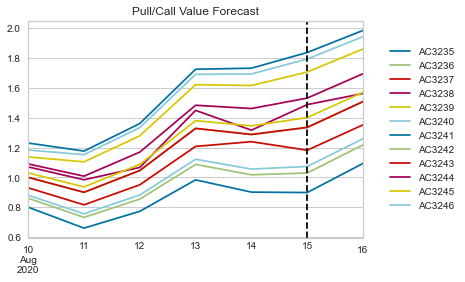

In [21]:
pt = complete_data.iloc[:,:12].plot()
plt.title("Pull/Call Value Forecast")
plt.legend(loc=5,bbox_to_anchor=(1.3, 0.5))
plt.axvline(datetime.datetime(2020, 8, 15),linestyle='--',color='black');

The values right to the dotted lines are predicted by the model i.e. "16th Aug" Values.

In [22]:
aug16.to_csv("Answer_files/file_02.csv",index=True)
#Finally The predicted values are exported as .csv file
aug16

Stock Index,AC3235,AC3236,AC3237,AC3238,AC3239,AC3240,AC3241,AC3242,AC3243,AC3244,...,AD2729,AD2730,AD2731,AD2732,AD2733,AD2734,AD2735,AD2736,AD2737,AD2738
2020-08-16,1.093348,1.217661,1.351871,1.694194,1.859945,1.942821,1.984258,1.507725,1.507725,1.56153,...,1.217661,0.678971,0.989753,1.487006,1.528444,1.217661,0.761846,0.824003,1.072629,0.969035
